### DL_Assignment 2 
Implement a cnn model having 2 convolusion block, each convolusion block consists of convolusion layer which is followed by a relu function and then downsampled using max pooling. The 2nd conv block is then followed by 2 fully connected layers. We need to draw a scatter plot of gradient norm vs epoch.

Import the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
import torchvision.datasets as dataset
import torchvision.transforms as transforms

In [2]:
print(torch.__version__)

1.7.0+cu101


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Download the data and then normalize it so that we get a distribution with a mean of 0.1307 and a standard deviation of 0.3081.

In [4]:
train_set = dataset.MNIST(
    root = './data',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081))                                 
    ])
)

test_set = dataset.MNIST(
    root = './data',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081))                                 
    ])
)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# initialising batch size for training and testing
bs = 100

In [25]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = bs, shuffle=True)

To calculate the output dimension, we will use formula : `W_out = ((W_in - F + 2P)/S) + 1`

where 
W : width,
S : number of stride,
F = filter size (or kernel size)

`1st Layer = Conv1 (using 5 * 5 kernel) + Relu + MaxPooling (using 2 * 2 kernel)`
>The output of 1st layer is 14 * 14 * 32 i.e., there are 32 channels and each image is having 14 * 14 dimension.

`2nd Layer = Conv2 (using 5 * 5 kernel) + Relu + MaxPooling (using 2 * 2 kernel)`
>The output of 2nd layer is 7 * 7 * 64 i.e., there are 64 channels and each image is having 7 * 7 dimension.
 
We have used maxpooling to down-sample the data by reducing the effective image size by a factor of 2. 

#### Define the model

In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride = 1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride = 1, padding=2)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7*7*64, 1000)
        self.fc2 = nn.Linear(1000,10)
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        # flatten the data dimension from 7*7*64 into 3136*1
        x = x.view(-1, 7*7*64)
        x = self.fc1(x)
        x = self.fc2(x)
# No need to use softmax function as it is already included in CrossEntropyLoss()
        return x

In [8]:
num_epochs = 300
log_interval = 10
learning_rate = 0.01
train_counter = []
train_losses = []

#### Define the loss function and optimization algorithm

In [9]:
model = ConvNet()
model.to(device) # transfer to GPU if available
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

In [27]:
model

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

#### Training the model

In [10]:
gradient_norm = []
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 55)
# Train the model
    model.train() 
    for batch_idx, data_set in enumerate(train_loader):
        
        data , target = data_set
        data = data.to(device)
        target = target.to(device)
        # Forward propagation
        optimizer.zero_grad()  # set gradients to zero
        output = model(data)   
        output.to(device)
        loss = loss_func(output,target) # compute loss

        # Back propagation and perform adam optimization
        loss.backward() # calculate gradients
        optimizer.step()  # update weights

        if batch_idx % log_interval == 0:
         print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
           epoch, batch_idx * len(data), len(train_loader.dataset),
           100. * batch_idx / len(train_loader), loss.item()))
         
        train_losses.append(loss.item())
        train_counter.append(
         (batch_idx*100) + ((epoch-1)*len(train_loader.dataset)))
    
    # Calculating gradient norm
    gradients = []
    for name, param in model.named_parameters():
        if param.requires_grad and "bias" not in name:
            # Uncomment any of the below line if you want to see the gradient values
            #print (name, param.grad.data)
            #print(f'{name}.grad', param.grad, epoch)
            gradients.append(torch.flatten(param.grad.data))
    print(torch.norm(torch.cat([gradients[0],gradients[1],gradients[2],gradients[3]],dim=0)))
    gradient_norm.append(torch.norm(torch.cat([gradients[0],gradients[1],gradients[2],gradients[3]],dim=0)).item())

Streaming output truncated to the last 5000 lines.
Train Epoch: 220 [38000/60000 (63%)]	 Loss: 2.305628
Train Epoch: 220 [39000/60000 (65%)]	 Loss: 2.301950
Train Epoch: 220 [40000/60000 (67%)]	 Loss: 2.300644
Train Epoch: 220 [41000/60000 (68%)]	 Loss: 2.292352
Train Epoch: 220 [42000/60000 (70%)]	 Loss: 2.313114
Train Epoch: 220 [43000/60000 (72%)]	 Loss: 2.308220
Train Epoch: 220 [44000/60000 (73%)]	 Loss: 2.302917
Train Epoch: 220 [45000/60000 (75%)]	 Loss: 2.292389
Train Epoch: 220 [46000/60000 (77%)]	 Loss: 2.303607
Train Epoch: 220 [47000/60000 (78%)]	 Loss: 2.303130
Train Epoch: 220 [48000/60000 (80%)]	 Loss: 2.305922
Train Epoch: 220 [49000/60000 (82%)]	 Loss: 2.289412
Train Epoch: 220 [50000/60000 (83%)]	 Loss: 2.310157
Train Epoch: 220 [51000/60000 (85%)]	 Loss: 2.313935
Train Epoch: 220 [52000/60000 (87%)]	 Loss: 2.311523
Train Epoch: 220 [53000/60000 (88%)]	 Loss: 2.296247
Train Epoch: 220 [54000/60000 (90%)]	 Loss: 2.327805
Train Epoch: 220 [55000/60000 (92%)]	 Loss: 2.29

In [12]:
# Gradient norm for each epoch
print(gradient_norm)

[0.055645402520895004, 0.01695345900952816, 0.03712749481201172, 0.0316828154027462, 0.030406413599848747, 0.02353578433394432, 0.022049065679311752, 0.03254808485507965, 0.06246017664670944, 0.025636686012148857, 0.052707817405462265, 0.03796205669641495, 0.05540471151471138, 0.048125654458999634, 0.0230899415910244, 0.02637120522558689, 0.022689511999487877, 0.017028357833623886, 0.025624379515647888, 0.037525322288274765, 0.038516815751791, 0.01556331105530262, 0.017111940309405327, 0.04600197449326515, 0.03704741597175598, 0.015522798523306847, 0.06347928941249847, 0.03524792194366455, 0.018581509590148926, 0.013627494685351849, 0.04621228575706482, 0.024798749014735222, 0.026161842048168182, 0.03642154484987259, 0.059904228895902634, 0.015412164852023125, 0.03779621794819832, 0.02073632925748825, 0.02158040925860405, 0.017520032823085785, 0.017408527433872223, 0.036699194461107254, 0.02086525410413742, 0.04082804173231125, 0.056595299392938614, 0.02765156328678131, 0.0288449693471

In [13]:
ep = [e for e in range(num_epochs)]
#ep

#### Evaluating and testing the model

In [26]:
correct = 0
total = 0
pred = []
# Test the model
model.eval()

for data, target in test_loader:
  data, target = data.to(device), target.to(device)
  output = model(data)
  _, predicted = torch.max(output.data,1)
  pred.append(output)
  total += target.size(0)
  correct += (predicted == target).sum().item()

print('The test accuracy of the 2-layered cnn model on the {} test images: {} %'.format(len(test_set),(correct / (total)) * 100))

The test accuracy of the 2-layered cnn model on the 10000 test images: 11.35 %


#### Plot of gradient norm vs epoch

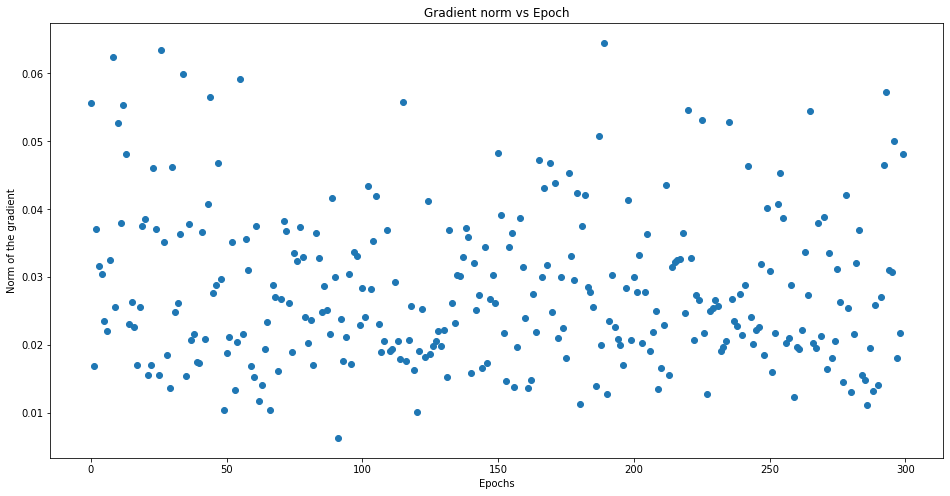

In [17]:
fig = plt.figure()
fig.set_size_inches(16, 8)
plt.xlabel("Epochs")
plt.ylabel("Norm of the gradient")
plt.scatter(ep,gradient_norm)
#plt.plot(ep,gradient_norm)
plt.title("Gradient norm vs Epoch")
plt.savefig('scatter plot of gradient norm vs epoch (with 300 epochs).pdf',dpi = 300)

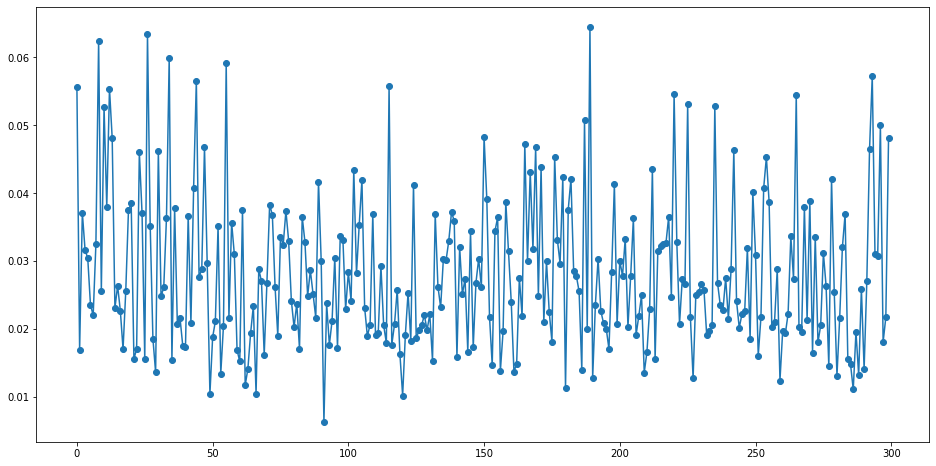

In [20]:
fig = plt.figure()
fig.set_size_inches(16, 8)
plt.scatter(ep,gradient_norm)
plt.plot(ep,gradient_norm)
plt.savefig('scatter_line plot of gradient norm vs epoch (with 300 epochs).pdf',dpi = 300);

Below is the plot of gradient norm vs epoch (considering total number of epoch = 100).
In that case, the test accuracy of the model on the 10000 test images was 95.22 %.

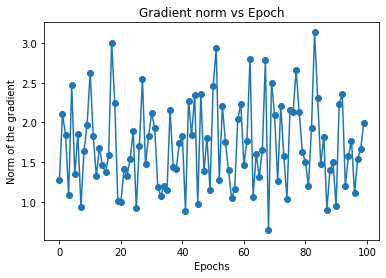

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Norm of the gradient")
plt.scatter(ep,gradient_norm)
plt.plot(ep,gradient_norm)
plt.title("Gradient norm vs Epoch")
plt.savefig('scatter plot of gradient norm vs epoch (with 100 epoch).pdf', dpi = 300)
plt.show();

In [24]:
from google.colab import files
files.download('scatter plot of gradient norm vs epoch (with 300 epochs).pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
files.download('scatter_line plot of gradient norm vs epoch (with 300 epochs).pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('scatter plot of gradient norm vs epoch (with 100 epoch).pdf')